In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from torch.utils.data import Dataset
import os
import copy
from tensorboardX import SummaryWriter
from PIL import Image
import torchvision.transforms as transforms

plt.ion()   # interactive mode
%matplotlib inline

In [2]:
class KDEFDataset(Dataset):
    def __init__(self, root='C:\\Users\\bikas\\Documents\\research\\KDEF', transforms_=None, idx=[]):
        self.transform = transforms_
        self.files = []

        for path, subdirs, files in os.walk(root):
            for name in files:
                self.files.append(os.path.join(path, name))
        
        self.files =  [self.files[i] for i in idx]
        self.classes = {
             "AF":0,
             "AN":1,
             "DI":2,
             "HA":3,
             "NE":4,
             "SA":5,
             "SU":6
        }
        
        for index in range(4900):
            filepath = self.files[index % len(self.files)]
            filename = filepath.split('\\')[-1]
            if filename[4:6] not in self.classes:
                print(filepath)

    def __getitem__(self, index):
        filepath = self.files[index % len(self.files)]

        filename = filepath.split('\\')[-1]
        img = self.transform(Image.open(filepath))
        label = self.classes[filename[4:6]]

        return img, label

    def __len__(self):
        return len(self.files)

Load Data
---------


In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

idx = np.random.permutation(4900)
idx = {'val': idx[0:490], 'train': idx[490:]}

dataloaders = {x: torch.utils.data.DataLoader(KDEFDataset(transforms_=data_transforms[x], idx=idx[x]), batch_size=8,
                                             shuffle=True)
              for x in ['train', 'val']}

dataset_sizes = {x: len(idx[x]) for x in ['train', 'val']}
class_names = 7

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualize a few images


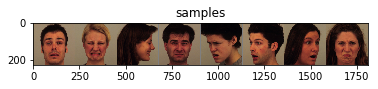

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title='samples')

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [5]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, dataloaders, writer=None, i=0,  num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            

            writer.add_scalar(phase+"/loss", epoch_loss, epoch)
            writer.add_scalar(phase+"/acc", epoch_acc, epoch)


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'saved/resnet_'+str(i)+'.pt')

        print()
        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc

Visualizing the model predictions

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [6]:
accuracies = []


for i in range(20):
    index = list(np.random.permutation(4900))
    idx = {'val': index[0:490], 'train': index[490:]}

    dataloaders = {x: torch.utils.data.DataLoader(KDEFDataset(transforms_=data_transforms[x], idx=idx[x]), batch_size=8,
                                             shuffle=True)
              for x in ['train', 'val']}

    model_ft = models.densenet161(pretrained=True)
    num_ftrs = model_ft.classifier.in_features
    model_ft.classifier = nn.Linear(num_ftrs, class_names)

    model_ft = model_ft.to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.1)
    writer = SummaryWriter('./logs/densenet161_kfold_'+str(i))

    model_ft, best_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                                     dataloaders, writer, i, num_epochs=20)
    
    accuracies.append(best_acc.item())
    print("\n\n\n------------------------------------\nAccuracies ", accuracies)
    print(np.array(accuracies).mean())
    print("\n\n")

Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:10<00:00,  2.20it/s]


train Loss: 1.0907 Acc: 0.5875


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.84it/s]


val Loss: 0.3475 Acc: 0.8816

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.4263 Acc: 0.8526


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.82it/s]


val Loss: 0.2165 Acc: 0.9265

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.2687 Acc: 0.9075


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.89it/s]


val Loss: 0.1677 Acc: 0.9408

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.2052 Acc: 0.9299


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.88it/s]


val Loss: 0.1738 Acc: 0.9490

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.1426 Acc: 0.9526


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.84it/s]


val Loss: 0.1106 Acc: 0.9551

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0900 Acc: 0.9726


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.83it/s]


val Loss: 0.0961 Acc: 0.9653

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0603 Acc: 0.9832


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.89it/s]


val Loss: 0.0973 Acc: 0.9653

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0464 Acc: 0.9873


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.77it/s]


val Loss: 0.1051 Acc: 0.9673

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0455 Acc: 0.9866


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.83it/s]


val Loss: 0.1036 Acc: 0.9673

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0321 Acc: 0.9923


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.85it/s]


val Loss: 0.0847 Acc: 0.9653

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0252 Acc: 0.9964


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.80it/s]


val Loss: 0.0869 Acc: 0.9735

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0279 Acc: 0.9959


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.89it/s]


val Loss: 0.0902 Acc: 0.9694

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.0266 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.89it/s]


val Loss: 0.0882 Acc: 0.9714

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0303 Acc: 0.9939


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.89it/s]


val Loss: 0.0965 Acc: 0.9673

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0246 Acc: 0.9948


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.85it/s]


val Loss: 0.0758 Acc: 0.9694

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.0257 Acc: 0.9948


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.86it/s]


val Loss: 0.0819 Acc: 0.9694

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0269 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.85it/s]


val Loss: 0.0854 Acc: 0.9694

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0276 Acc: 0.9948


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.86it/s]


val Loss: 0.0827 Acc: 0.9714

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0285 Acc: 0.9946


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.84it/s]


val Loss: 0.0908 Acc: 0.9633

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0311 Acc: 0.9925


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.81it/s]


val Loss: 0.0775 Acc: 0.9735

Training complete in 80m 58s
Best val Acc: 0.973469



------------------------------------
Accuracies  [0.9734693877551022]
0.9734693877551022



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 1.0963 Acc: 0.5805


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.86it/s]


val Loss: 0.4364 Acc: 0.8469

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.4626 Acc: 0.8406


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.84it/s]


val Loss: 0.2437 Acc: 0.9204

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.2804 Acc: 0.9061


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.83it/s]


val Loss: 0.2590 Acc: 0.9082

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:55<00:00,  2.35it/s]


train Loss: 0.1866 Acc: 0.9395


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.46it/s]


val Loss: 0.1487 Acc: 0.9388

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:01<00:00,  2.29it/s]


train Loss: 0.1520 Acc: 0.9528


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.86it/s]


val Loss: 0.1306 Acc: 0.9490

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.1252 Acc: 0.9585


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.88it/s]


val Loss: 0.1954 Acc: 0.9163

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0663 Acc: 0.9810


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.87it/s]


val Loss: 0.1135 Acc: 0.9551

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0466 Acc: 0.9866


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.86it/s]


val Loss: 0.1044 Acc: 0.9592

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:09<00:00,  2.21it/s]


train Loss: 0.0462 Acc: 0.9889


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.54it/s]


val Loss: 0.1047 Acc: 0.9612

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:55<00:00,  2.35it/s]


train Loss: 0.0406 Acc: 0.9898


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.68it/s]


val Loss: 0.1090 Acc: 0.9571

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:54<00:00,  2.35it/s]


train Loss: 0.0349 Acc: 0.9916


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.68it/s]


val Loss: 0.1024 Acc: 0.9592

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:53<00:00,  2.37it/s]


train Loss: 0.0337 Acc: 0.9925


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.45it/s]


val Loss: 0.0931 Acc: 0.9673

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:52<00:00,  2.37it/s]


train Loss: 0.0334 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.16it/s]


val Loss: 0.0836 Acc: 0.9633

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:07<00:00,  2.23it/s]


train Loss: 0.0280 Acc: 0.9943


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.14it/s]


val Loss: 0.0903 Acc: 0.9633

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:09<00:00,  2.21it/s]


train Loss: 0.0304 Acc: 0.9946


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.24it/s]


val Loss: 0.0933 Acc: 0.9633

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:01<00:00,  2.28it/s]


train Loss: 0.0308 Acc: 0.9937


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.79it/s]


val Loss: 0.1033 Acc: 0.9571

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:52<00:00,  2.38it/s]


train Loss: 0.0299 Acc: 0.9923


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.81it/s]


val Loss: 0.0864 Acc: 0.9673

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0299 Acc: 0.9946


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.81it/s]


val Loss: 0.0858 Acc: 0.9633

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0305 Acc: 0.9934


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.82it/s]


val Loss: 0.1042 Acc: 0.9551

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0320 Acc: 0.9934


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.86it/s]


val Loss: 0.0918 Acc: 0.9612

Training complete in 82m 14s
Best val Acc: 0.967347



------------------------------------
Accuracies  [0.9734693877551022, 0.9673469387755103]
0.9704081632653062



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 1.1040 Acc: 0.5812


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.82it/s]


val Loss: 0.4150 Acc: 0.8551

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:53<00:00,  2.37it/s]


train Loss: 0.4282 Acc: 0.8524


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.81it/s]


val Loss: 0.2684 Acc: 0.9061

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.2863 Acc: 0.9020


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.83it/s]


val Loss: 0.2790 Acc: 0.8939

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.1952 Acc: 0.9347


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.85it/s]


val Loss: 0.1275 Acc: 0.9531

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.1478 Acc: 0.9526


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.85it/s]


val Loss: 0.2006 Acc: 0.9306

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.1164 Acc: 0.9639


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.74it/s]


val Loss: 0.1126 Acc: 0.9694

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0550 Acc: 0.9853


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.81it/s]


val Loss: 0.0755 Acc: 0.9816

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:49<00:00,  2.40it/s]


train Loss: 0.0503 Acc: 0.9882


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.76it/s]


val Loss: 0.0777 Acc: 0.9694

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0418 Acc: 0.9893


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.84it/s]


val Loss: 0.0660 Acc: 0.9735

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0308 Acc: 0.9937


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.87it/s]


val Loss: 0.0747 Acc: 0.9714

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0355 Acc: 0.9912


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.81it/s]


val Loss: 0.0692 Acc: 0.9714

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0286 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.88it/s]


val Loss: 0.0597 Acc: 0.9837

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:53<00:00,  2.36it/s]


train Loss: 0.0289 Acc: 0.9946


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.80it/s]


val Loss: 0.0586 Acc: 0.9837

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0307 Acc: 0.9934


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.81it/s]


val Loss: 0.0601 Acc: 0.9837

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0273 Acc: 0.9950


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.83it/s]


val Loss: 0.0586 Acc: 0.9816

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:04<00:00,  2.26it/s]


train Loss: 0.0268 Acc: 0.9939


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.55it/s]


val Loss: 0.0648 Acc: 0.9776

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:00<00:00,  2.30it/s]


train Loss: 0.0245 Acc: 0.9950


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.59it/s]


val Loss: 0.0800 Acc: 0.9653

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:54<00:00,  2.35it/s]


train Loss: 0.0285 Acc: 0.9939


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.68it/s]


val Loss: 0.0670 Acc: 0.9735

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:52<00:00,  2.38it/s]


train Loss: 0.0265 Acc: 0.9950


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.89it/s]


val Loss: 0.0654 Acc: 0.9776

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0282 Acc: 0.9939


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.87it/s]


val Loss: 0.0648 Acc: 0.9816

Training complete in 80m 58s
Best val Acc: 0.983673



------------------------------------
Accuracies  [0.9734693877551022, 0.9673469387755103, 0.9836734693877552]
0.9748299319727892



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 1.1225 Acc: 0.5705


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.83it/s]


val Loss: 0.4459 Acc: 0.8347

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.4287 Acc: 0.8483


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.84it/s]


val Loss: 0.3201 Acc: 0.8673

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.3104 Acc: 0.8937


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.83it/s]


val Loss: 0.2201 Acc: 0.9367

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:52<00:00,  2.38it/s]


train Loss: 0.1758 Acc: 0.9417


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.75it/s]


val Loss: 0.2238 Acc: 0.9224

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:52<00:00,  2.37it/s]


train Loss: 0.1579 Acc: 0.9454


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.76it/s]


val Loss: 0.2295 Acc: 0.9204

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.1188 Acc: 0.9628


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.80it/s]


val Loss: 0.1355 Acc: 0.9633

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:49<00:00,  2.40it/s]


train Loss: 0.0598 Acc: 0.9848


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.87it/s]


val Loss: 0.1192 Acc: 0.9612

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0473 Acc: 0.9891


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.78it/s]


val Loss: 0.1271 Acc: 0.9633

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0373 Acc: 0.9925


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.84it/s]


val Loss: 0.1296 Acc: 0.9653

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0354 Acc: 0.9927


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.64it/s]


val Loss: 0.1158 Acc: 0.9694

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:16<00:00,  2.15it/s]


train Loss: 0.0303 Acc: 0.9946


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.44it/s]


val Loss: 0.1149 Acc: 0.9653

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:12<00:00,  2.18it/s]


train Loss: 0.0330 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.09it/s]


val Loss: 0.1291 Acc: 0.9694

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:21<00:00,  2.11it/s]


train Loss: 0.0299 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.12it/s]


val Loss: 0.1269 Acc: 0.9612

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:22<00:00,  2.11it/s]


train Loss: 0.0288 Acc: 0.9943


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.09it/s]


val Loss: 0.1287 Acc: 0.9571

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:22<00:00,  2.11it/s]


train Loss: 0.0251 Acc: 0.9946


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.10it/s]


val Loss: 0.1261 Acc: 0.9612

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:16<00:00,  2.15it/s]


train Loss: 0.0273 Acc: 0.9943


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.86it/s]


val Loss: 0.1250 Acc: 0.9571

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0288 Acc: 0.9952


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.85it/s]


val Loss: 0.1185 Acc: 0.9653

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:54<00:00,  2.35it/s]


train Loss: 0.0235 Acc: 0.9959


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.18it/s]


val Loss: 0.1287 Acc: 0.9673

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:06<00:00,  2.24it/s]


train Loss: 0.0256 Acc: 0.9943


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.15it/s]


val Loss: 0.1395 Acc: 0.9653

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:06<00:00,  2.24it/s]


train Loss: 0.0280 Acc: 0.9939


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.12it/s]


val Loss: 0.1203 Acc: 0.9612

Training complete in 84m 4s
Best val Acc: 0.969388



------------------------------------
Accuracies  [0.9734693877551022, 0.9673469387755103, 0.9836734693877552, 0.9693877551020409]
0.9734693877551022



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:06<00:00,  2.24it/s]


train Loss: 1.1421 Acc: 0.5592


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.16it/s]


val Loss: 0.5602 Acc: 0.7878

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:06<00:00,  2.24it/s]


train Loss: 0.4471 Acc: 0.8454


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.22it/s]


val Loss: 0.2801 Acc: 0.9041

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:06<00:00,  2.24it/s]


train Loss: 0.2698 Acc: 0.9061


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.13it/s]


val Loss: 0.2524 Acc: 0.9143

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:04<00:00,  2.26it/s]


train Loss: 0.1888 Acc: 0.9356


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.20it/s]


val Loss: 0.2305 Acc: 0.9286

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:56<00:00,  2.33it/s]


train Loss: 0.1430 Acc: 0.9546


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.82it/s]


val Loss: 0.2288 Acc: 0.9224

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.1163 Acc: 0.9635


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.75it/s]


val Loss: 0.1991 Acc: 0.9429

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:59<00:00,  2.31it/s]


train Loss: 0.0709 Acc: 0.9789


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.29it/s]


val Loss: 0.1556 Acc: 0.9531

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:10<00:00,  2.21it/s]


train Loss: 0.0496 Acc: 0.9871


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.09it/s]


val Loss: 0.1435 Acc: 0.9571

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:11<00:00,  2.20it/s]


train Loss: 0.0407 Acc: 0.9902


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.14it/s]


val Loss: 0.1368 Acc: 0.9592

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:10<00:00,  2.20it/s]


train Loss: 0.0405 Acc: 0.9900


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.13it/s]


val Loss: 0.1236 Acc: 0.9612

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:10<00:00,  2.20it/s]


train Loss: 0.0327 Acc: 0.9923


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.13it/s]


val Loss: 0.1278 Acc: 0.9592

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:11<00:00,  2.20it/s]


train Loss: 0.0333 Acc: 0.9927


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.13it/s]


val Loss: 0.1385 Acc: 0.9592

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:54<00:00,  2.35it/s]


train Loss: 0.0252 Acc: 0.9961


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.52it/s]


val Loss: 0.1367 Acc: 0.9592

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:12<00:00,  2.19it/s]


train Loss: 0.0303 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.17it/s]


val Loss: 0.1304 Acc: 0.9653

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:19<00:00,  2.13it/s]


train Loss: 0.0250 Acc: 0.9957


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.68it/s]


val Loss: 0.1158 Acc: 0.9673

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:05<00:00,  2.25it/s]


train Loss: 0.0254 Acc: 0.9959


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.76it/s]


val Loss: 0.1290 Acc: 0.9653

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0282 Acc: 0.9925


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.80it/s]


val Loss: 0.1114 Acc: 0.9633

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:49<00:00,  2.40it/s]


train Loss: 0.0300 Acc: 0.9943


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.82it/s]


val Loss: 0.1198 Acc: 0.9653

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0266 Acc: 0.9943


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.83it/s]


val Loss: 0.1124 Acc: 0.9653

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:49<00:00,  2.40it/s]


train Loss: 0.0314 Acc: 0.9930


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.79it/s]


val Loss: 0.1255 Acc: 0.9653

Training complete in 84m 55s
Best val Acc: 0.967347



------------------------------------
Accuracies  [0.9734693877551022, 0.9673469387755103, 0.9836734693877552, 0.9693877551020409, 0.9673469387755103]
0.9722448979591839



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:02<00:00,  2.28it/s]


train Loss: 1.1248 Acc: 0.5728


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.44it/s]


val Loss: 0.4412 Acc: 0.8265

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.4613 Acc: 0.8401


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.84it/s]


val Loss: 0.2431 Acc: 0.9204

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:04<00:00,  2.26it/s]


train Loss: 0.2772 Acc: 0.9061


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.59it/s]


val Loss: 0.2116 Acc: 0.9224

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:09<00:00,  2.21it/s]


train Loss: 0.2060 Acc: 0.9324


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.00it/s]


val Loss: 0.1748 Acc: 0.9306

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:52<00:00,  2.38it/s]


train Loss: 0.1350 Acc: 0.9574


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.78it/s]


val Loss: 0.2317 Acc: 0.9163

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:56<00:00,  2.33it/s]


train Loss: 0.1032 Acc: 0.9689


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.52it/s]


val Loss: 0.1823 Acc: 0.9429

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:00<00:00,  2.29it/s]


train Loss: 0.0644 Acc: 0.9821


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.99it/s]


val Loss: 0.1188 Acc: 0.9551

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:04<00:00,  2.26it/s]


train Loss: 0.0441 Acc: 0.9898


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.45it/s]


val Loss: 0.0970 Acc: 0.9653

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:01<00:00,  2.29it/s]


train Loss: 0.0417 Acc: 0.9893


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.52it/s]


val Loss: 0.0991 Acc: 0.9612

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:59<00:00,  2.31it/s]


train Loss: 0.0362 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.29it/s]


val Loss: 0.0858 Acc: 0.9673

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:03<00:00,  2.27it/s]


train Loss: 0.0308 Acc: 0.9930


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.79it/s]


val Loss: 0.0803 Acc: 0.9694

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:56<00:00,  2.33it/s]


train Loss: 0.0315 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.74it/s]


val Loss: 0.0837 Acc: 0.9694

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0276 Acc: 0.9950


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.72it/s]


val Loss: 0.0910 Acc: 0.9653

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0291 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.85it/s]


val Loss: 0.0772 Acc: 0.9735

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0272 Acc: 0.9948


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.80it/s]


val Loss: 0.0843 Acc: 0.9694

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0290 Acc: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.79it/s]


val Loss: 0.0914 Acc: 0.9673

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0265 Acc: 0.9950


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.73it/s]


val Loss: 0.0789 Acc: 0.9694

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0263 Acc: 0.9946


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.81it/s]


val Loss: 0.0781 Acc: 0.9714

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0308 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.82it/s]


val Loss: 0.0814 Acc: 0.9694

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0231 Acc: 0.9964


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.83it/s]


val Loss: 0.0779 Acc: 0.9714

Training complete in 82m 34s
Best val Acc: 0.973469



------------------------------------
Accuracies  [0.9734693877551022, 0.9673469387755103, 0.9836734693877552, 0.9693877551020409, 0.9673469387755103, 0.9734693877551022]
0.972448979591837



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 1.0788 Acc: 0.5980


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.80it/s]


val Loss: 0.3748 Acc: 0.8857

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.4247 Acc: 0.8553


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.81it/s]


val Loss: 0.3235 Acc: 0.8735

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.2775 Acc: 0.9082


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.85it/s]


val Loss: 0.2970 Acc: 0.8980

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.1781 Acc: 0.9458


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.81it/s]


val Loss: 0.2218 Acc: 0.9082

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.1519 Acc: 0.9476


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.76it/s]


val Loss: 0.1904 Acc: 0.9327

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.1177 Acc: 0.9630


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.80it/s]


val Loss: 0.0871 Acc: 0.9816

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0658 Acc: 0.9848


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.84it/s]


val Loss: 0.0695 Acc: 0.9857

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0460 Acc: 0.9907


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.85it/s]


val Loss: 0.0751 Acc: 0.9776

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0422 Acc: 0.9907


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.77it/s]


val Loss: 0.0802 Acc: 0.9735

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0386 Acc: 0.9916


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.86it/s]


val Loss: 0.0715 Acc: 0.9755

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0378 Acc: 0.9907


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.86it/s]


val Loss: 0.0716 Acc: 0.9735

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0362 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.86it/s]


val Loss: 0.0683 Acc: 0.9714

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0345 Acc: 0.9939


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.77it/s]


val Loss: 0.0666 Acc: 0.9796

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0280 Acc: 0.9937


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.84it/s]


val Loss: 0.0672 Acc: 0.9816

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0273 Acc: 0.9957


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.87it/s]


val Loss: 0.0743 Acc: 0.9714

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0309 Acc: 0.9934


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.77it/s]


val Loss: 0.0671 Acc: 0.9755

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0287 Acc: 0.9934


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.86it/s]


val Loss: 0.0671 Acc: 0.9735

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0316 Acc: 0.9934


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.86it/s]


val Loss: 0.0833 Acc: 0.9755

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0268 Acc: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.73it/s]


val Loss: 0.0675 Acc: 0.9755

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0242 Acc: 0.9957


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.86it/s]


val Loss: 0.0707 Acc: 0.9776

Training complete in 80m 25s
Best val Acc: 0.985714



------------------------------------
Accuracies  [0.9734693877551022, 0.9673469387755103, 0.9836734693877552, 0.9693877551020409, 0.9673469387755103, 0.9734693877551022, 0.9857142857142858]
0.9743440233236154



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 1.1037 Acc: 0.5760


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.84it/s]


val Loss: 0.5139 Acc: 0.8388

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.4391 Acc: 0.8478


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.84it/s]


val Loss: 0.2890 Acc: 0.8898

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.2840 Acc: 0.9009


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.79it/s]


val Loss: 0.2105 Acc: 0.9163

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.1925 Acc: 0.9370


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.77it/s]


val Loss: 0.2251 Acc: 0.9102

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.1363 Acc: 0.9526


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.78it/s]


val Loss: 0.1435 Acc: 0.9510

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.1096 Acc: 0.9642


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.87it/s]


val Loss: 0.1625 Acc: 0.9469

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:49<00:00,  2.41it/s]


train Loss: 0.0645 Acc: 0.9823


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.87it/s]


val Loss: 0.0827 Acc: 0.9633

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0477 Acc: 0.9884


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.71it/s]


val Loss: 0.0848 Acc: 0.9592

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0465 Acc: 0.9873


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.75it/s]


val Loss: 0.0889 Acc: 0.9633

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0457 Acc: 0.9878


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.83it/s]


val Loss: 0.0987 Acc: 0.9592

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0330 Acc: 0.9948


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.72it/s]


val Loss: 0.0913 Acc: 0.9633

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0383 Acc: 0.9916


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.82it/s]


val Loss: 0.0816 Acc: 0.9673

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0304 Acc: 0.9937


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.70it/s]


val Loss: 0.0841 Acc: 0.9612

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0294 Acc: 0.9939


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.85it/s]


val Loss: 0.0814 Acc: 0.9653

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0248 Acc: 0.9964


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.85it/s]


val Loss: 0.0809 Acc: 0.9673

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0326 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.73it/s]


val Loss: 0.0802 Acc: 0.9694

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0301 Acc: 0.9934


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.76it/s]


val Loss: 0.0963 Acc: 0.9633

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0281 Acc: 0.9946


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.85it/s]


val Loss: 0.0824 Acc: 0.9673

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0264 Acc: 0.9948


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.77it/s]


val Loss: 0.0774 Acc: 0.9653

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0287 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.75it/s]


val Loss: 0.0921 Acc: 0.9673

Training complete in 80m 29s
Best val Acc: 0.969388



------------------------------------
Accuracies  [0.9734693877551022, 0.9673469387755103, 0.9836734693877552, 0.9693877551020409, 0.9673469387755103, 0.9734693877551022, 0.9857142857142858, 0.9693877551020409]
0.9737244897959185



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 1.1178 Acc: 0.5726


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.77it/s]


val Loss: 0.4832 Acc: 0.8347

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.4570 Acc: 0.8361


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.72it/s]


val Loss: 0.3054 Acc: 0.9041

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.2801 Acc: 0.9032


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.76it/s]


val Loss: 0.2194 Acc: 0.9122

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.2184 Acc: 0.9252


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.87it/s]


val Loss: 0.1728 Acc: 0.9408

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.1286 Acc: 0.9612


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.82it/s]


val Loss: 0.1425 Acc: 0.9531

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.1062 Acc: 0.9667


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.84it/s]


val Loss: 0.1496 Acc: 0.9429

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0663 Acc: 0.9828


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.84it/s]


val Loss: 0.1099 Acc: 0.9694

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0485 Acc: 0.9878


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.87it/s]


val Loss: 0.0931 Acc: 0.9714

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0491 Acc: 0.9873


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.85it/s]


val Loss: 0.0744 Acc: 0.9796

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0427 Acc: 0.9891


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.84it/s]


val Loss: 0.0779 Acc: 0.9776

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0356 Acc: 0.9925


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.81it/s]


val Loss: 0.0978 Acc: 0.9755

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0323 Acc: 0.9923


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.85it/s]


val Loss: 0.0799 Acc: 0.9776

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0285 Acc: 0.9948


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.78it/s]


val Loss: 0.0897 Acc: 0.9714

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0287 Acc: 0.9950


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.84it/s]


val Loss: 0.0817 Acc: 0.9755

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0265 Acc: 0.9959


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.80it/s]


val Loss: 0.0739 Acc: 0.9735

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0270 Acc: 0.9957


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.88it/s]


val Loss: 0.0853 Acc: 0.9694

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0247 Acc: 0.9961


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.76it/s]


val Loss: 0.0796 Acc: 0.9714

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0269 Acc: 0.9946


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.82it/s]


val Loss: 0.0907 Acc: 0.9714

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0298 Acc: 0.9918


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.78it/s]


val Loss: 0.0927 Acc: 0.9714

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0310 Acc: 0.9912


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.80it/s]


val Loss: 0.0876 Acc: 0.9714

Training complete in 80m 27s
Best val Acc: 0.979592



------------------------------------
Accuracies  [0.9734693877551022, 0.9673469387755103, 0.9836734693877552, 0.9693877551020409, 0.9673469387755103, 0.9734693877551022, 0.9857142857142858, 0.9693877551020409, 0.979591836734694]
0.9743764172335602



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 1.0981 Acc: 0.5834


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.81it/s]


val Loss: 0.5333 Acc: 0.8041

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.4326 Acc: 0.8517


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.79it/s]


val Loss: 0.2822 Acc: 0.9061

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.2864 Acc: 0.9077


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.88it/s]


val Loss: 0.2122 Acc: 0.9143

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.1808 Acc: 0.9429


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.84it/s]


val Loss: 0.2121 Acc: 0.9265

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.1496 Acc: 0.9490


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.76it/s]


val Loss: 0.1524 Acc: 0.9531

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.1178 Acc: 0.9621


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.84it/s]


val Loss: 0.1810 Acc: 0.9469

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0573 Acc: 0.9866


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.79it/s]


val Loss: 0.1276 Acc: 0.9633

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0527 Acc: 0.9857


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.84it/s]


val Loss: 0.1213 Acc: 0.9653

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0428 Acc: 0.9907


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.85it/s]


val Loss: 0.1200 Acc: 0.9653

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0364 Acc: 0.9918


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.78it/s]


val Loss: 0.1242 Acc: 0.9633

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0378 Acc: 0.9925


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.74it/s]


val Loss: 0.1024 Acc: 0.9653

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0338 Acc: 0.9912


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.84it/s]


val Loss: 0.1170 Acc: 0.9633

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0299 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.83it/s]


val Loss: 0.1396 Acc: 0.9571

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0306 Acc: 0.9943


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.84it/s]


val Loss: 0.1131 Acc: 0.9633

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0308 Acc: 0.9930


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.83it/s]


val Loss: 0.1253 Acc: 0.9571

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:53<00:00,  2.36it/s]


train Loss: 0.0300 Acc: 0.9937


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.36it/s]


val Loss: 0.1197 Acc: 0.9571

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:55<00:00,  2.34it/s]


train Loss: 0.0263 Acc: 0.9946


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.90it/s]


val Loss: 0.1221 Acc: 0.9592

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0305 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.74it/s]


val Loss: 0.1205 Acc: 0.9612

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0306 Acc: 0.9937


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.87it/s]


val Loss: 0.1298 Acc: 0.9531

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0272 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.84it/s]


val Loss: 0.1180 Acc: 0.9612

Training complete in 80m 37s
Best val Acc: 0.965306



------------------------------------
Accuracies  [0.9734693877551022, 0.9673469387755103, 0.9836734693877552, 0.9693877551020409, 0.9673469387755103, 0.9734693877551022, 0.9857142857142858, 0.9693877551020409, 0.979591836734694, 0.9653061224489797]
0.9734693877551021



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 1.1043 Acc: 0.5780


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.84it/s]


val Loss: 0.5652 Acc: 0.7898

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.4438 Acc: 0.8449


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.91it/s]


val Loss: 0.2545 Acc: 0.9122

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.2696 Acc: 0.9100


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.38it/s]


val Loss: 0.2254 Acc: 0.9245

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:59<00:00,  2.30it/s]


train Loss: 0.1952 Acc: 0.9370


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.70it/s]


val Loss: 0.2579 Acc: 0.9163

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:01<00:00,  2.29it/s]


train Loss: 0.1476 Acc: 0.9519


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.78it/s]


val Loss: 0.1835 Acc: 0.9408

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:52<00:00,  2.37it/s]


train Loss: 0.1161 Acc: 0.9633


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.11it/s]


val Loss: 0.1424 Acc: 0.9469

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:05<00:00,  2.25it/s]


train Loss: 0.0746 Acc: 0.9773


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.45it/s]


val Loss: 0.1089 Acc: 0.9653

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:55<00:00,  2.35it/s]


train Loss: 0.0537 Acc: 0.9855


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.80it/s]


val Loss: 0.1011 Acc: 0.9694

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:59<00:00,  2.30it/s]


train Loss: 0.0420 Acc: 0.9912


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.54it/s]


val Loss: 0.0966 Acc: 0.9612

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:56<00:00,  2.34it/s]


train Loss: 0.0409 Acc: 0.9891


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.42it/s]


val Loss: 0.0978 Acc: 0.9673

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:03<00:00,  2.27it/s]


train Loss: 0.0334 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.48it/s]


val Loss: 0.0967 Acc: 0.9673

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:01<00:00,  2.29it/s]


train Loss: 0.0360 Acc: 0.9907


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.49it/s]


val Loss: 0.0976 Acc: 0.9633

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:58<00:00,  2.32it/s]


train Loss: 0.0318 Acc: 0.9921


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.78it/s]


val Loss: 0.1052 Acc: 0.9571

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:57<00:00,  2.32it/s]


train Loss: 0.0332 Acc: 0.9925


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.61it/s]


val Loss: 0.1003 Acc: 0.9633

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:59<00:00,  2.31it/s]


train Loss: 0.0387 Acc: 0.9902


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.62it/s]


val Loss: 0.0950 Acc: 0.9673

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:56<00:00,  2.34it/s]


train Loss: 0.0272 Acc: 0.9946


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.78it/s]


val Loss: 0.0946 Acc: 0.9714

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.0317 Acc: 0.9925


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.79it/s]


val Loss: 0.0900 Acc: 0.9673

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0338 Acc: 0.9923


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.79it/s]


val Loss: 0.0876 Acc: 0.9673

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0299 Acc: 0.9943


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.76it/s]


val Loss: 0.0927 Acc: 0.9653

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0292 Acc: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.75it/s]


val Loss: 0.0961 Acc: 0.9673

Training complete in 82m 31s
Best val Acc: 0.971429



------------------------------------
Accuracies  [0.9734693877551022, 0.9673469387755103, 0.9836734693877552, 0.9693877551020409, 0.9673469387755103, 0.9734693877551022, 0.9857142857142858, 0.9693877551020409, 0.979591836734694, 0.9653061224489797, 0.9714285714285715]
0.9732838589981447



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 1.0928 Acc: 0.5887


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.72it/s]


val Loss: 0.4764 Acc: 0.8102

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.4237 Acc: 0.8587


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.80it/s]


val Loss: 0.2890 Acc: 0.8980

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.2721 Acc: 0.9045


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.79it/s]


val Loss: 0.2360 Acc: 0.9245

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:00<00:00,  2.30it/s]


train Loss: 0.1806 Acc: 0.9388


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.32it/s]


val Loss: 0.2878 Acc: 0.8959

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:01<00:00,  2.28it/s]


train Loss: 0.1364 Acc: 0.9565


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.80it/s]


val Loss: 0.1691 Acc: 0.9469

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:01<00:00,  2.29it/s]


train Loss: 0.1230 Acc: 0.9615


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.62it/s]


val Loss: 0.1454 Acc: 0.9673

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:53<00:00,  2.37it/s]


train Loss: 0.0595 Acc: 0.9844


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.49it/s]


val Loss: 0.1350 Acc: 0.9633

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:55<00:00,  2.34it/s]


train Loss: 0.0465 Acc: 0.9896


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.16it/s]


val Loss: 0.1292 Acc: 0.9653

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:57<00:00,  2.33it/s]


train Loss: 0.0395 Acc: 0.9916


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.50it/s]


val Loss: 0.1273 Acc: 0.9551

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:53<00:00,  2.37it/s]


train Loss: 0.0347 Acc: 0.9937


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.13it/s]


val Loss: 0.1265 Acc: 0.9612

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:53<00:00,  2.36it/s]


train Loss: 0.0327 Acc: 0.9939


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.64it/s]


val Loss: 0.1210 Acc: 0.9653

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:52<00:00,  2.37it/s]


train Loss: 0.0322 Acc: 0.9930


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.64it/s]


val Loss: 0.1244 Acc: 0.9633

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:53<00:00,  2.37it/s]


train Loss: 0.0300 Acc: 0.9937


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.65it/s]


val Loss: 0.1211 Acc: 0.9673

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:57<00:00,  2.32it/s]


train Loss: 0.0307 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.58it/s]


val Loss: 0.1258 Acc: 0.9612

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:54<00:00,  2.36it/s]


train Loss: 0.0281 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.59it/s]


val Loss: 0.1255 Acc: 0.9673

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:53<00:00,  2.37it/s]


train Loss: 0.0267 Acc: 0.9948


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.70it/s]


val Loss: 0.1189 Acc: 0.9653

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:52<00:00,  2.37it/s]


train Loss: 0.0294 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.78it/s]


val Loss: 0.1223 Acc: 0.9673

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:57<00:00,  2.33it/s]


train Loss: 0.0302 Acc: 0.9934


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.82it/s]


val Loss: 0.1202 Acc: 0.9653

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0294 Acc: 0.9946


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.92it/s]


val Loss: 0.1215 Acc: 0.9633

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0276 Acc: 0.9952


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.88it/s]


val Loss: 0.1211 Acc: 0.9653

Training complete in 81m 55s
Best val Acc: 0.967347



------------------------------------
Accuracies  [0.9734693877551022, 0.9673469387755103, 0.9836734693877552, 0.9693877551020409, 0.9673469387755103, 0.9734693877551022, 0.9857142857142858, 0.9693877551020409, 0.979591836734694, 0.9653061224489797, 0.9714285714285715, 0.9673469387755103]
0.9727891156462585



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:54<00:00,  2.35it/s]


train Loss: 1.0996 Acc: 0.5871


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.33it/s]


val Loss: 0.4876 Acc: 0.8306

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:07<00:00,  2.23it/s]


train Loss: 0.4673 Acc: 0.8397


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.78it/s]


val Loss: 0.2940 Acc: 0.8959

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:00<00:00,  2.30it/s]


train Loss: 0.2914 Acc: 0.9018


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.94it/s]


val Loss: 0.2293 Acc: 0.9184

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:04<00:00,  2.26it/s]


train Loss: 0.2047 Acc: 0.9363


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.11it/s]


val Loss: 0.1757 Acc: 0.9531

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:06<00:00,  2.24it/s]


train Loss: 0.1373 Acc: 0.9515


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.48it/s]


val Loss: 0.1280 Acc: 0.9653

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:55<00:00,  2.34it/s]


train Loss: 0.1192 Acc: 0.9619


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.59it/s]


val Loss: 0.1267 Acc: 0.9612

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:54<00:00,  2.36it/s]


train Loss: 0.0727 Acc: 0.9787


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.49it/s]


val Loss: 0.0968 Acc: 0.9714

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:52<00:00,  2.38it/s]


train Loss: 0.0487 Acc: 0.9871


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.79it/s]


val Loss: 0.0899 Acc: 0.9735

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0414 Acc: 0.9898


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.81it/s]


val Loss: 0.0939 Acc: 0.9694

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0337 Acc: 0.9943


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.76it/s]


val Loss: 0.0879 Acc: 0.9714

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0335 Acc: 0.9930


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.86it/s]


val Loss: 0.0927 Acc: 0.9714

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0353 Acc: 0.9916


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.76it/s]


val Loss: 0.0912 Acc: 0.9735

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0287 Acc: 0.9925


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.80it/s]


val Loss: 0.0793 Acc: 0.9673

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.0293 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.78it/s]


val Loss: 0.0926 Acc: 0.9735

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:49<00:00,  2.40it/s]


train Loss: 0.0290 Acc: 0.9937


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.42it/s]


val Loss: 0.0841 Acc: 0.9694

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:03<00:00,  2.26it/s]


train Loss: 0.0261 Acc: 0.9964


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.04it/s]


val Loss: 0.0877 Acc: 0.9755

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:59<00:00,  2.31it/s]


train Loss: 0.0300 Acc: 0.9934


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.74it/s]


val Loss: 0.0793 Acc: 0.9735

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:57<00:00,  2.33it/s]


train Loss: 0.0277 Acc: 0.9952


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.64it/s]


val Loss: 0.0805 Acc: 0.9714

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:57<00:00,  2.32it/s]


train Loss: 0.0274 Acc: 0.9943


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.62it/s]


val Loss: 0.0825 Acc: 0.9755

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:00<00:00,  2.30it/s]


train Loss: 0.0292 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.07it/s]


val Loss: 0.0910 Acc: 0.9694

Training complete in 82m 37s
Best val Acc: 0.975510



------------------------------------
Accuracies  [0.9734693877551022, 0.9673469387755103, 0.9836734693877552, 0.9693877551020409, 0.9673469387755103, 0.9734693877551022, 0.9857142857142858, 0.9693877551020409, 0.979591836734694, 0.9653061224489797, 0.9714285714285715, 0.9673469387755103, 0.9755102040816327]
0.9729984301412873



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:58<00:00,  2.31it/s]


train Loss: 1.1075 Acc: 0.5766


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.33it/s]


val Loss: 0.5966 Acc: 0.7816

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:02<00:00,  2.28it/s]


train Loss: 0.4506 Acc: 0.8381


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.66it/s]


val Loss: 0.2943 Acc: 0.8939

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:55<00:00,  2.34it/s]


train Loss: 0.2499 Acc: 0.9150


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.75it/s]


val Loss: 0.1790 Acc: 0.9306

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:02<00:00,  2.28it/s]


train Loss: 0.1925 Acc: 0.9345


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.10it/s]


val Loss: 0.2312 Acc: 0.9204

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:04<00:00,  2.26it/s]


train Loss: 0.1561 Acc: 0.9517


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.08it/s]


val Loss: 0.1925 Acc: 0.9367

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:59<00:00,  2.30it/s]


train Loss: 0.1033 Acc: 0.9664


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.07it/s]


val Loss: 0.1731 Acc: 0.9449

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:57<00:00,  2.32it/s]


train Loss: 0.0632 Acc: 0.9816


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.56it/s]


val Loss: 0.1219 Acc: 0.9592

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:53<00:00,  2.37it/s]


train Loss: 0.0404 Acc: 0.9907


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.80it/s]


val Loss: 0.1251 Acc: 0.9612

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0377 Acc: 0.9905


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.73it/s]


val Loss: 0.0967 Acc: 0.9714

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0364 Acc: 0.9927


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.66it/s]


val Loss: 0.1238 Acc: 0.9612

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0392 Acc: 0.9907


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.89it/s]


val Loss: 0.1003 Acc: 0.9714

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0314 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.82it/s]


val Loss: 0.1122 Acc: 0.9612

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:05<00:00,  2.25it/s]


train Loss: 0.0299 Acc: 0.9937


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.24it/s]


val Loss: 0.1039 Acc: 0.9714

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:59<00:00,  2.31it/s]


train Loss: 0.0292 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.62it/s]


val Loss: 0.1200 Acc: 0.9653

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:53<00:00,  2.37it/s]


train Loss: 0.0259 Acc: 0.9948


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.61it/s]


val Loss: 0.1136 Acc: 0.9694

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:56<00:00,  2.34it/s]


train Loss: 0.0293 Acc: 0.9952


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.68it/s]


val Loss: 0.1229 Acc: 0.9612

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:52<00:00,  2.38it/s]


train Loss: 0.0272 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.65it/s]


val Loss: 0.1163 Acc: 0.9673

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:52<00:00,  2.37it/s]


train Loss: 0.0280 Acc: 0.9946


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.62it/s]


val Loss: 0.1099 Acc: 0.9714

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:52<00:00,  2.37it/s]


train Loss: 0.0329 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.66it/s]


val Loss: 0.1052 Acc: 0.9633

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:53<00:00,  2.36it/s]


train Loss: 0.0304 Acc: 0.9934


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.19it/s]


val Loss: 0.1148 Acc: 0.9612

Training complete in 82m 29s
Best val Acc: 0.971429



------------------------------------
Accuracies  [0.9734693877551022, 0.9673469387755103, 0.9836734693877552, 0.9693877551020409, 0.9673469387755103, 0.9734693877551022, 0.9857142857142858, 0.9693877551020409, 0.979591836734694, 0.9653061224489797, 0.9714285714285715, 0.9673469387755103, 0.9755102040816327, 0.9714285714285715]
0.9728862973760933



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:02<00:00,  2.28it/s]


train Loss: 1.1041 Acc: 0.5739


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.82it/s]


val Loss: 0.5163 Acc: 0.8000

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:04<00:00,  2.26it/s]


train Loss: 0.4570 Acc: 0.8392


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.76it/s]


val Loss: 0.3264 Acc: 0.8878

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.2766 Acc: 0.9068


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.77it/s]


val Loss: 0.1994 Acc: 0.9388

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.2007 Acc: 0.9324


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.86it/s]


val Loss: 0.1609 Acc: 0.9408

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.1479 Acc: 0.9533


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.75it/s]


val Loss: 0.2090 Acc: 0.9306

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.1145 Acc: 0.9587


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.78it/s]


val Loss: 0.1634 Acc: 0.9469

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0651 Acc: 0.9816


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.80it/s]


val Loss: 0.1115 Acc: 0.9551

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0506 Acc: 0.9871


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.78it/s]


val Loss: 0.0868 Acc: 0.9633

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0426 Acc: 0.9898


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.73it/s]


val Loss: 0.1045 Acc: 0.9673

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0404 Acc: 0.9921


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.74it/s]


val Loss: 0.0917 Acc: 0.9694

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0380 Acc: 0.9921


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.74it/s]


val Loss: 0.0855 Acc: 0.9653

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0338 Acc: 0.9921


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.78it/s]


val Loss: 0.1237 Acc: 0.9633

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0317 Acc: 0.9937


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.75it/s]


val Loss: 0.0848 Acc: 0.9673

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.0294 Acc: 0.9934


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.36it/s]


val Loss: 0.0930 Acc: 0.9653

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:05<00:00,  2.25it/s]


train Loss: 0.0318 Acc: 0.9950


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.95it/s]


val Loss: 0.1112 Acc: 0.9633

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:15<00:00,  2.16it/s]


train Loss: 0.0299 Acc: 0.9930


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.01it/s]


val Loss: 0.0896 Acc: 0.9633

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:11<00:00,  2.19it/s]


train Loss: 0.0341 Acc: 0.9921


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.15it/s]


val Loss: 0.0795 Acc: 0.9694

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:10<00:00,  2.20it/s]


train Loss: 0.0265 Acc: 0.9957


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.20it/s]


val Loss: 0.0940 Acc: 0.9653

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:10<00:00,  2.20it/s]


train Loss: 0.0259 Acc: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.17it/s]


val Loss: 0.1035 Acc: 0.9633

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:07<00:00,  2.23it/s]


train Loss: 0.0281 Acc: 0.9950


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.80it/s]


val Loss: 0.0954 Acc: 0.9673

Training complete in 83m 6s
Best val Acc: 0.969388



------------------------------------
Accuracies  [0.9734693877551022, 0.9673469387755103, 0.9836734693877552, 0.9693877551020409, 0.9673469387755103, 0.9734693877551022, 0.9857142857142858, 0.9693877551020409, 0.979591836734694, 0.9653061224489797, 0.9714285714285715, 0.9673469387755103, 0.9755102040816327, 0.9714285714285715, 0.9693877551020409]
0.9726530612244898



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 1.0705 Acc: 0.5984


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.67it/s]


val Loss: 0.4579 Acc: 0.8327

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.4404 Acc: 0.8408


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.69it/s]


val Loss: 0.3417 Acc: 0.8837

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:52<00:00,  2.38it/s]


train Loss: 0.2668 Acc: 0.9132


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.77it/s]


val Loss: 0.2925 Acc: 0.9020

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.1882 Acc: 0.9401


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.78it/s]


val Loss: 0.1585 Acc: 0.9490

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.1374 Acc: 0.9580


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.80it/s]


val Loss: 0.1840 Acc: 0.9306

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.1171 Acc: 0.9630


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.74it/s]


val Loss: 0.1404 Acc: 0.9531

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0662 Acc: 0.9828


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.78it/s]


val Loss: 0.1077 Acc: 0.9592

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0462 Acc: 0.9889


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.79it/s]


val Loss: 0.0941 Acc: 0.9612

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0430 Acc: 0.9893


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.73it/s]


val Loss: 0.0916 Acc: 0.9653

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.0373 Acc: 0.9930


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.80it/s]


val Loss: 0.0852 Acc: 0.9673

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.0305 Acc: 0.9950


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.76it/s]


val Loss: 0.0878 Acc: 0.9694

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.0422 Acc: 0.9878


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.77it/s]


val Loss: 0.0908 Acc: 0.9592

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.0303 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.76it/s]


val Loss: 0.0912 Acc: 0.9694

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0285 Acc: 0.9952


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.71it/s]


val Loss: 0.0921 Acc: 0.9531

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.0271 Acc: 0.9952


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.78it/s]


val Loss: 0.0911 Acc: 0.9653

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.0287 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.81it/s]


val Loss: 0.0873 Acc: 0.9673

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.0255 Acc: 0.9957


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.68it/s]


val Loss: 0.0852 Acc: 0.9633

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0298 Acc: 0.9943


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.74it/s]


val Loss: 0.0954 Acc: 0.9592

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0273 Acc: 0.9961


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.75it/s]


val Loss: 0.0822 Acc: 0.9694

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.0242 Acc: 0.9959


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.72it/s]


val Loss: 0.0849 Acc: 0.9653

Training complete in 80m 48s
Best val Acc: 0.969388



------------------------------------
Accuracies  [0.9734693877551022, 0.9673469387755103, 0.9836734693877552, 0.9693877551020409, 0.9673469387755103, 0.9734693877551022, 0.9857142857142858, 0.9693877551020409, 0.979591836734694, 0.9653061224489797, 0.9714285714285715, 0.9673469387755103, 0.9755102040816327, 0.9714285714285715, 0.9693877551020409, 0.9693877551020409]
0.9724489795918368



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 1.0878 Acc: 0.5875


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.76it/s]


val Loss: 0.4267 Acc: 0.8531

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.4449 Acc: 0.8424


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.73it/s]


val Loss: 0.2761 Acc: 0.8980

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.2686 Acc: 0.9079


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.75it/s]


val Loss: 0.2344 Acc: 0.9204

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.2069 Acc: 0.9333


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.78it/s]


val Loss: 0.1852 Acc: 0.9408

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.1530 Acc: 0.9510


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.72it/s]


val Loss: 0.1664 Acc: 0.9388

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.0991 Acc: 0.9714


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.73it/s]


val Loss: 0.2261 Acc: 0.9204

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.0609 Acc: 0.9812


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.79it/s]


val Loss: 0.1348 Acc: 0.9531

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.0428 Acc: 0.9907


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.76it/s]


val Loss: 0.1166 Acc: 0.9571

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.0458 Acc: 0.9873


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.78it/s]


val Loss: 0.1126 Acc: 0.9612

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.0406 Acc: 0.9898


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.80it/s]


val Loss: 0.1081 Acc: 0.9633

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.0343 Acc: 0.9921


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.75it/s]


val Loss: 0.1026 Acc: 0.9592

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0364 Acc: 0.9918


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.71it/s]


val Loss: 0.1137 Acc: 0.9571

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0289 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.80it/s]


val Loss: 0.1118 Acc: 0.9551

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0308 Acc: 0.9934


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.69it/s]


val Loss: 0.1081 Acc: 0.9592

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.0279 Acc: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.77it/s]


val Loss: 0.1062 Acc: 0.9571

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0262 Acc: 0.9948


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.74it/s]


val Loss: 0.1029 Acc: 0.9612

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0334 Acc: 0.9927


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.68it/s]


val Loss: 0.1034 Acc: 0.9592

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.0265 Acc: 0.9943


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.73it/s]


val Loss: 0.1098 Acc: 0.9653

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.0310 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.79it/s]


val Loss: 0.1095 Acc: 0.9633

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0281 Acc: 0.9937


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.76it/s]


val Loss: 0.1072 Acc: 0.9612

Training complete in 80m 47s
Best val Acc: 0.965306



------------------------------------
Accuracies  [0.9734693877551022, 0.9673469387755103, 0.9836734693877552, 0.9693877551020409, 0.9673469387755103, 0.9734693877551022, 0.9857142857142858, 0.9693877551020409, 0.979591836734694, 0.9653061224489797, 0.9714285714285715, 0.9673469387755103, 0.9755102040816327, 0.9714285714285715, 0.9693877551020409, 0.9693877551020409, 0.9653061224489797]
0.9720288115246101



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 1.0748 Acc: 0.6014


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.70it/s]


val Loss: 0.4180 Acc: 0.8449

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.4258 Acc: 0.8469


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.66it/s]


val Loss: 0.2839 Acc: 0.9041

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.2813 Acc: 0.9036


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.69it/s]


val Loss: 0.2074 Acc: 0.9224

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.1805 Acc: 0.9390


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.81it/s]


val Loss: 0.2987 Acc: 0.8898

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.1565 Acc: 0.9474


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.76it/s]


val Loss: 0.1231 Acc: 0.9592

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.1063 Acc: 0.9671


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.73it/s]


val Loss: 0.1370 Acc: 0.9592

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.0670 Acc: 0.9800


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.82it/s]


val Loss: 0.1011 Acc: 0.9653

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.0434 Acc: 0.9914


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.81it/s]


val Loss: 0.0914 Acc: 0.9714

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0425 Acc: 0.9905


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.78it/s]


val Loss: 0.0973 Acc: 0.9673

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.0354 Acc: 0.9907


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.78it/s]


val Loss: 0.0897 Acc: 0.9776

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0324 Acc: 0.9930


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.72it/s]


val Loss: 0.0900 Acc: 0.9694

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0290 Acc: 0.9943


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.78it/s]


val Loss: 0.0856 Acc: 0.9714

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.0299 Acc: 0.9930


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.78it/s]


val Loss: 0.0848 Acc: 0.9735

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.0351 Acc: 0.9896


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.75it/s]


val Loss: 0.0804 Acc: 0.9694

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0261 Acc: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.74it/s]


val Loss: 0.0858 Acc: 0.9735

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:52<00:00,  2.37it/s]


train Loss: 0.0321 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.69it/s]


val Loss: 0.0871 Acc: 0.9714

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.0253 Acc: 0.9961


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.75it/s]


val Loss: 0.0864 Acc: 0.9755

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.0276 Acc: 0.9950


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.70it/s]


val Loss: 0.0827 Acc: 0.9714

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0298 Acc: 0.9937


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.72it/s]


val Loss: 0.0866 Acc: 0.9735

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0257 Acc: 0.9964


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.76it/s]


val Loss: 0.0899 Acc: 0.9776

Training complete in 80m 48s
Best val Acc: 0.977551



------------------------------------
Accuracies  [0.9734693877551022, 0.9673469387755103, 0.9836734693877552, 0.9693877551020409, 0.9673469387755103, 0.9734693877551022, 0.9857142857142858, 0.9693877551020409, 0.979591836734694, 0.9653061224489797, 0.9714285714285715, 0.9673469387755103, 0.9755102040816327, 0.9714285714285715, 0.9693877551020409, 0.9693877551020409, 0.9653061224489797, 0.9775510204081633]
0.9723356009070296



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 1.1117 Acc: 0.5823


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.77it/s]


val Loss: 0.5343 Acc: 0.8020

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.4541 Acc: 0.8447


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.77it/s]


val Loss: 0.3235 Acc: 0.8694

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.2668 Acc: 0.9063


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.33it/s]


val Loss: 0.2942 Acc: 0.8878

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.1929 Acc: 0.9363


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.70it/s]


val Loss: 0.2688 Acc: 0.9020

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.1329 Acc: 0.9587


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.66it/s]


val Loss: 0.1667 Acc: 0.9306

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:59<00:00,  2.31it/s]


train Loss: 0.1215 Acc: 0.9610


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.79it/s]


val Loss: 0.1484 Acc: 0.9469

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:49<00:00,  2.40it/s]


train Loss: 0.0766 Acc: 0.9796


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.76it/s]


val Loss: 0.0824 Acc: 0.9714

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:49<00:00,  2.40it/s]


train Loss: 0.0481 Acc: 0.9880


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.74it/s]


val Loss: 0.0821 Acc: 0.9633

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:49<00:00,  2.41it/s]


train Loss: 0.0412 Acc: 0.9921


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.84it/s]


val Loss: 0.0820 Acc: 0.9694

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:49<00:00,  2.40it/s]


train Loss: 0.0391 Acc: 0.9909


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.77it/s]


val Loss: 0.0774 Acc: 0.9735

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:48<00:00,  2.42it/s]


train Loss: 0.0378 Acc: 0.9907


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.71it/s]


val Loss: 0.0761 Acc: 0.9673

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:49<00:00,  2.41it/s]


train Loss: 0.0319 Acc: 0.9927


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.79it/s]


val Loss: 0.0862 Acc: 0.9694

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:58<00:00,  2.32it/s]


train Loss: 0.0311 Acc: 0.9934


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.44it/s]


val Loss: 0.0832 Acc: 0.9633

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:04<00:00,  2.26it/s]


train Loss: 0.0335 Acc: 0.9914


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.23it/s]


val Loss: 0.0854 Acc: 0.9653

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:08<00:00,  2.22it/s]


train Loss: 0.0312 Acc: 0.9930


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.23it/s]


val Loss: 0.1059 Acc: 0.9653

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:07<00:00,  2.23it/s]


train Loss: 0.0306 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.77it/s]


val Loss: 0.0739 Acc: 0.9714

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0325 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.81it/s]


val Loss: 0.0752 Acc: 0.9633

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:08<00:00,  2.22it/s]


train Loss: 0.0271 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.24it/s]


val Loss: 0.0748 Acc: 0.9653

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [04:12<00:00,  2.19it/s]


train Loss: 0.0353 Acc: 0.9912


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.03it/s]


val Loss: 0.0931 Acc: 0.9633

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:59<00:00,  2.30it/s]


train Loss: 0.0304 Acc: 0.9943


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.70it/s]


val Loss: 0.0863 Acc: 0.9714

Training complete in 82m 24s
Best val Acc: 0.973469



------------------------------------
Accuracies  [0.9734693877551022, 0.9673469387755103, 0.9836734693877552, 0.9693877551020409, 0.9673469387755103, 0.9734693877551022, 0.9857142857142858, 0.9693877551020409, 0.979591836734694, 0.9653061224489797, 0.9714285714285715, 0.9673469387755103, 0.9755102040816327, 0.9714285714285715, 0.9693877551020409, 0.9693877551020409, 0.9653061224489797, 0.9775510204081633, 0.9734693877551022]
0.9723952738990335



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 1.0848 Acc: 0.5868


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.64it/s]


val Loss: 0.4446 Acc: 0.8469

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.4412 Acc: 0.8440


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.69it/s]


val Loss: 0.2600 Acc: 0.9143

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.2581 Acc: 0.9138


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.70it/s]


val Loss: 0.1698 Acc: 0.9408

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.1821 Acc: 0.9379


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.73it/s]


val Loss: 0.1690 Acc: 0.9531

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.1376 Acc: 0.9558


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.73it/s]


val Loss: 0.2834 Acc: 0.9082

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.1134 Acc: 0.9608


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.74it/s]


val Loss: 0.1495 Acc: 0.9531

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:52<00:00,  2.38it/s]


train Loss: 0.0533 Acc: 0.9868


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.64it/s]


val Loss: 0.1137 Acc: 0.9633

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:52<00:00,  2.38it/s]


train Loss: 0.0438 Acc: 0.9884


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.64it/s]


val Loss: 0.1100 Acc: 0.9673

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.38it/s]


train Loss: 0.0425 Acc: 0.9878


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.46it/s]


val Loss: 0.1112 Acc: 0.9633

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0401 Acc: 0.9907


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.68it/s]


val Loss: 0.1112 Acc: 0.9653

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:49<00:00,  2.40it/s]


train Loss: 0.0342 Acc: 0.9927


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.72it/s]


val Loss: 0.1123 Acc: 0.9592

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0327 Acc: 0.9918


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.65it/s]


val Loss: 0.1073 Acc: 0.9592

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:51<00:00,  2.39it/s]


train Loss: 0.0322 Acc: 0.9925


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.65it/s]


val Loss: 0.1061 Acc: 0.9592

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:53<00:00,  2.37it/s]


train Loss: 0.0287 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.71it/s]


val Loss: 0.1158 Acc: 0.9694

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:49<00:00,  2.41it/s]


train Loss: 0.0271 Acc: 0.9957


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.77it/s]


val Loss: 0.1059 Acc: 0.9612

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.40it/s]


train Loss: 0.0307 Acc: 0.9925


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.71it/s]


val Loss: 0.1067 Acc: 0.9571

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:55<00:00,  2.35it/s]


train Loss: 0.0287 Acc: 0.9934


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.32it/s]


val Loss: 0.1004 Acc: 0.9694

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:54<00:00,  2.35it/s]


train Loss: 0.0311 Acc: 0.9918


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.62it/s]


val Loss: 0.1087 Acc: 0.9694

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0273 Acc: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.69it/s]


val Loss: 0.1020 Acc: 0.9694

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [03:50<00:00,  2.39it/s]


train Loss: 0.0304 Acc: 0.9937


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.76it/s]


val Loss: 0.1180 Acc: 0.9653

Training complete in 80m 49s
Best val Acc: 0.969388



------------------------------------
Accuracies  [0.9734693877551022, 0.9673469387755103, 0.9836734693877552, 0.9693877551020409, 0.9673469387755103, 0.9734693877551022, 0.9857142857142858, 0.9693877551020409, 0.979591836734694, 0.9653061224489797, 0.9714285714285715, 0.9673469387755103, 0.9755102040816327, 0.9714285714285715, 0.9693877551020409, 0.9693877551020409, 0.9653061224489797, 0.9775510204081633, 0.9734693877551022, 0.9693877551020409]
0.9722448979591839



